# Enhanced License Plate Detection with Bidirectional FPN

This notebook implements an improved license plate detection model using a bidirectional Feature Pyramid Network (BiFPN) architecture. The goal is to achieve a mean IoU of 0.6 or higher, specifically by improving detection of small license plates which form the majority of the dataset.

### Key improvements over the previous model:

1. **Enhanced BiFPN Architecture** with bidirectional feature flow and attention mechanisms
2. **Size-Aware Loss Functions** that place greater emphasis on width/height accuracy
3. **Small Plate Focused Augmentation** with adaptive strategies based on plate size
4. **Improved Training Strategies** including cyclic learning rates and focused early stopping

## Step 1: Imports and Setup

In [9]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import random
import gc
import time
from IPython.display import clear_output
from sklearn.model_selection import train_test_split  # Add this import


# Add the project root directory to the path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules from the license plate detection package
from license_plate_detection.data.enhanced_augmentation import (
    augment_data_with_small_plate_focus, 
    create_tf_data_augmenter
)
from license_plate_detection.models.enhanced_losses import (
    ultra_plate_detection_loss,
    enhanced_ciou_loss,
    enhanced_focal_loss,
    enhanced_iou_metric
)
from license_plate_detection.models.enhanced_fpn import (
    create_bifpn_license_plate_detector,
    enable_gradient_checkpointing
)
from license_plate_detection.train.scheduler import (
    create_lr_scheduler,
    )
from license_plate_detection.data.loader import get_data_path, load_license_plate_dataset
from license_plate_detection.data.augmentation import visualize_augmentation
from license_plate_detection.utils.memory_optimizations import optimize_memory_usage, enable_gradient_checkpointing, clean_memory, setup_gpu_memory_growth
from license_plate_detection.train.trainer import create_efficient_data_pipeline
from license_plate_detection.evaluation.evaluator import evaluate_model_comprehensive
from license_plate_detection.utils.analysis import analyze_error_patterns
from license_plate_detection.evaluation.error_analysis import advanced_error_visualization
from license_plate_detection.utils.visualization import (
    visualize_prediction
)
from license_plate_detection.data.augmentation import augment_data

# Define split_dataset function if not available in imported modules
def split_dataset(X, y, test_size=0.2, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Set seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Set image size - using a higher resolution for better small plate detection
IMAGE_SIZE = (320, 320)  # Previous model used (224, 224)

# Configure TensorFlow to handle GPU memory more efficiently
setup_gpu_memory_growth()

# Check for available GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for device in tf.config.list_physical_devices():
    print(f"Found device: {device.name}")

No GPUs found
Num GPUs Available:  0
Found device: /physical_device:CPU:0


## Step 2: Data Loading and Preprocessing

Current directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Notebooks
Project root: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
Project root added to path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection
TensorFlow version: 2.18.0
Data path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset
Images directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\images
Annotations directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\Dataset\annotations


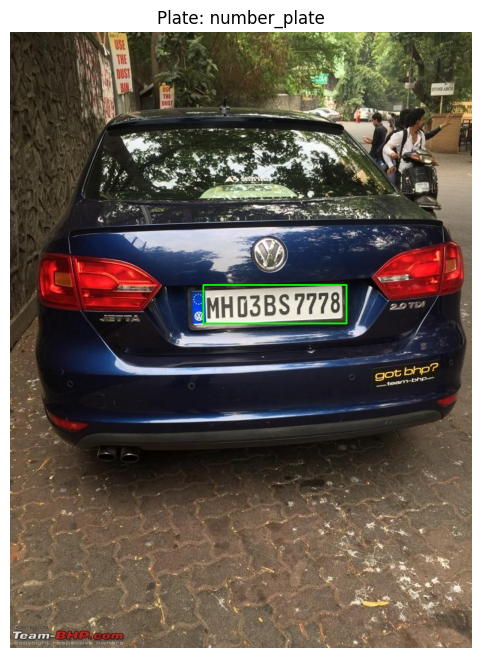

In [10]:
# Check if running in Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Dataset")
else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    # Add project root to path to fix import errors
    sys.path.insert(0, str(project_root))
    print(f"Project root added to path: {project_root}")
    DATA_PATH = project_root / "Dataset"

# Fix import redundancy by controlling import order and preventing code repetition
print(f"TensorFlow version: {tf.__version__}")

# Get paths to dataset using our refactored function
data_path = get_data_path()
IMAGES_PATH = data_path / "images"
ANNOTATIONS_PATH = data_path / "annotations"

# Check if the dataset paths exist
if not data_path.exists():
    raise FileNotFoundError(f"Data path does not exist: {data_path}\n"
                            "Please check the path or create the folder and add your data.")
if not IMAGES_PATH.exists():
    raise FileNotFoundError(f"Images directory does not exist: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise FileNotFoundError(f"Annotations directory does not exist: {ANNOTATIONS_PATH}")

print(f"Data path: {data_path}")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Load the dataset using the specialized function that returns a DataFrame
df = load_license_plate_dataset(ANNOTATIONS_PATH, IMAGES_PATH)

# Process the data to create X and y arrays that other cells expect
X = []  # List to hold images
y = []  # List to hold bounding boxes

# Convert DataFrame to X and y arrays
for idx, row in df.iterrows():
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, IMAGE_SIZE)  # Resize to model input size
    X.append(img)
    
    # Normalize bounding box to 0-1 range if needed
    img_h, img_w = img.shape[:2]
    x_norm = row["x"] / img_w
    y_norm = row["y"] / img_h
    w_norm = row["w"] / img_w
    h_norm = row["h"] / img_h
    y.append([x_norm, y_norm, w_norm, h_norm])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Visualize a sample image with its bounding box
if len(df) > 0:
    # Take first sample or specific index if available
    sample_idx = min(1000, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding box
    x, y_coord, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y_coord), (x + w, y_coord + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
    
    # Get statistics on plate sizes to understand the distribution
    df['area'] = df['w'] * df['h']
    df['aspect_ratio'] = df['w'] / df['h']
    
    # Calculate normalized areas relative to image size
    df['norm_area'] = df.apply(lambda row: (row['w'] * row['h']) / 
                             (cv2.imread(row['image_path']).shape[0] * 
                              cv2.imread(row['image_path']).shape[1]), axis=1)

### Enhanced Data Augmentation

In [12]:
# Access X and y to verify they exist
X_shape = X.shape
y_shape = y.shape
print(f"Found preprocessed data: {len(X)} images with shape {X_shape[1:]} and {len(y)} labels")

# Apply data augmentation with memory optimization
# Convert to float32 first to reduce memory usage
X = X.astype(np.float32) if X.dtype != np.float32 else X
y = y.astype(np.float32) if y.dtype != np.float32 else y

# Perform augmentation with reduced memory footprint
X_aug, y_aug = augment_data(X, y, augmentation_factor=3)

# Visualize some augmented samples - now shows original with its specific augmentations
visualize_augmentation(X, y, X_aug, y_aug, num_samples=4)

# 2. Split data into training and validation sets
X_train, X_val, y_train, y_val = split_dataset(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Found preprocessed data: 1122 images with shape (320, 320, 3) and 1122 labels
Starting enhanced data augmentation with factor 3...
Original dataset: 1122 images
Identified 368 small plates for focused augmentation
Augmenting image 0/1122...


OverflowError: Python integer -3 out of bounds for uint8

## Step 3: Enhanced BiFPN Architecture Implementation

We implement a bidirectional Feature Pyramid Network (BiFPN) with the following improvements:

1. **Bidirectional feature flow** - Information flows both top-down and bottom-up
2. **Channel and spatial attention** - To focus on important features
3. **Scale-aware detection heads** - Specialized processing for different feature scales
4. **Weighted feature fusion** - Better integration of multi-scale features
5. **Increased input resolution** - 320x320 instead of 224x224 for better small plate detection

In [13]:
# Create the enhanced BiFPN model
print("Creating enhanced BiFPN license plate detector...")
bifpn_model = create_bifpn_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Display model summary
bifpn_model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in bifpn_model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in bifpn_model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

# Apply memory optimizations
print("Applying gradient checkpointing to reduce memory usage...")
bifpn_model = enable_gradient_checkpointing(bifpn_model)

Creating enhanced BiFPN license plate detector...



Model: "bifpn_license_plate_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 160, 160,  │      4,864 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 160, 160,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swish1 (Activation) │ (None, 160, 160,  │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 80, 80,    │          0 │ swish1[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 80, 80,    │     73,856 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn1          │ (None, 80, 80,    │        512 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_swish1       │ (None, 80, 80,    │          0 │ block1_bn1[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 80, 80,    │    147,584 │ block1_swish1[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn2          │ (None, 80, 80,    │        512 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_gap          │ (None, 128)       │          0 │ block1_bn2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_reshape      │ (None, 1, 1, 128) │          0 │ block1_gap[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_conv1     │ (None, 1, 1, 32)  │      4,128 │ block1_reshape[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_conv2     │ (None, 1, 1, 128) │      4,224 │ block1_ca_conv1[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_conv     │ (None, 80, 80,    │      8,320 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ca_mul       │ (None, 80, 80,    │          0 │ block1_bn2[0][0], │
│ (Multiply)          │ 128)              │            │ block1_ca_conv2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_res_bn       │ (None, 80, 80,    │        512 │ block1_res_conv[

 Total params: 41,664,490 (158.94 MB)

 Trainable params: 41,638,506 (158.84 MB)

 Non-trainable params: 25,984 (101.50 KB)

Total parameters: 41,664,490
Trainable parameters: 41,638,506
Non-trainable parameters: 25,984
Applying gradient checkpointing to reduce memory usage...
Your TensorFlow version might not fully support gradient checkpointing


## Step 4: Advanced Training Configuration

In [ ]:
# Enable mixed precision training to reduce memory usage and increase speed on GPU
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision policy set to", policy.name)
    print("Compute dtype:", policy.compute_dtype)
    print("Variable dtype:", policy.variable_dtype)
except Exception as e:
    print(f"Could not enable mixed precision: {e} - using default precision")

# Clean up memory before starting training
clean_memory()

# Optimize training data formats
X_train, X_val, y_train, y_val = optimize_memory_usage(X_train, y_train, X_val, y_val)

print("Memory optimization complete. Training should now be more stable on GPU.")

In [ ]:
# Compile the model with our custom loss function
bifpn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=ultra_plate_detection_loss,  # Our enhanced loss function
    metrics=[
        enhanced_iou_metric,  # Primary metric for monitoring
        enhanced_ciou_loss,   # For monitoring size accuracy
        enhanced_focal_loss   # For monitoring hard example performance
    ]
)

# Set up callbacks with optimized hyperparameters
callbacks = [
    # Cosine annealing learning rate scheduler with warm restarts
    create_lr_scheduler(
        scheduler_type='cosine_restart',  
        initial_learning_rate=0.001,
        first_decay_steps=15,            # First cycle length
        t_mul=1.5,                       # Cycle length growth factor
        m_mul=0.75,                      # LR decay factor for each restart
        alpha=1e-5                       # Minimum LR value
    ),
    
    # More permissive early stopping focused on IoU improvement
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=20,                     # Longer patience for better convergence
        restore_best_weights=True,
        mode='max'
    ),
    
    # Model checkpoint to save best model
    keras.callbacks.ModelCheckpoint(
        'enhanced_bifpn_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir='./logs/bifpn_model',
        histogram_freq=1,
        update_freq='epoch'
    ),
    
    # Custom callback to reduce learning rate on plateau if needed
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_enhanced_iou_metric',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
]

# Create optimized data pipelines with improved batch size
BATCH_SIZE = 16  # Reduced from 24 to accommodate larger model and higher resolution

print("Creating efficient data pipeline...")
train_dataset, val_dataset = create_efficient_data_pipeline(
    X_train, y_train, X_val, y_val,
    batch_size=BATCH_SIZE
)

# Create on-the-fly augmentation function
tf_augmenter = create_tf_data_augmenter(cutout_prob=0.3, mixup_prob=0.2)

# Apply on-the-fly augmentation to the training dataset
augmented_train_dataset = train_dataset.map(
    tf_augmenter,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

In [ ]:
# Start training timer
start_time = time.time()

print("Starting Enhanced BiFPN model training...")
print("Training with the following improvements:")
print("- Bidirectional feature fusion through BiFPN")
print("- Enhanced attention mechanisms (channel, spatial, and dual)")
print("- Scale-aware detection heads for different feature levels")
print("- Ultra plate detection loss focusing on size accuracy")
print("- Small plate focused augmentation")
print("- Higher input resolution (320x320)")
print("- Cosine annealing LR schedule with warm restarts")

# Train the model
history = bifpn_model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=70,  # Increased from 50 for better convergence
    callbacks=callbacks,
    verbose=1
)

# Calculate training time
training_time = time.time() - start_time
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)
print(f"Training completed in {hours}h {minutes}m {seconds}s")

# Reference to trained model
bifpn_trained_model = bifpn_model

# Save the final model
bifpn_model.save('bifpn_license_plate_detector_final.h5')

### Training Visualization

In [ ]:
# Visualize training history
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)

# Plot IoU metric
plt.subplot(1, 3, 2)
plt.plot(history.history['enhanced_iou_metric'])
plt.plot(history.history['val_enhanced_iou_metric'])
plt.title('IoU Metric')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

# Plot focal loss component
plt.subplot(1, 3, 3)
plt.plot(history.history['enhanced_focal_loss'])
plt.plot(history.history['val_enhanced_focal_loss'])
plt.title('Focal Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
if history.history:
    epochs_trained = len(history.history['loss'])
    print(f"Total epochs trained: {epochs_trained}")
    
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    train_iou = history.history['enhanced_iou_metric'][-1]
    val_iou = history.history['val_enhanced_iou_metric'][-1]
    print(f"Final training IoU: {train_iou:.4f}")
    print(f"Final validation IoU: {val_iou:.4f}")
    
    # Get best IoU
    best_epoch = np.argmax(history.history['val_enhanced_iou_metric'])
    best_val_iou = history.history['val_enhanced_iou_metric'][best_epoch]
    print(f"Best validation IoU: {best_val_iou:.4f} (epoch {best_epoch+1})")
else:
    print("No training history found. Training may have failed.")

## Step 5: Model Evaluation

In [ ]:
# Generate predictions from the trained model
print("Generating predictions from the trained model...")
bifpn_predictions = bifpn_trained_model.predict(X_val)

# Run comprehensive evaluation
print("Running comprehensive evaluation...")
bifpn_results = evaluate_model_comprehensive(
    bifpn_trained_model,
    X_val,
    y_val,
    bifpn_predictions
)

print(f"BiFPN model mean IoU: {bifpn_results['mean_iu']:.4f}")
print(f"BiFPN model mAP@0.5: {bifpn_results['map50']:.4f}")

## Step 6: Error Analysis by Plate Size

In [ ]:
# Perform detailed error analysis by plate size categories
bifpn_error_analysis = analyze_error_patterns(
    model=bifpn_trained_model,
    X_val=X_val,
    y_val=y_val,
    y_pred=bifpn_predictions,
    plate_sizes=[box[2] * box[3] for box in y_val]
)

# Display detailed error metrics
print("\nDetailed Error Analysis:")
print(f"- Mean IoU: {bifpn_error_analysis['mean_iou']:.4f}")
print(f"- Position error: {bifpn_error_analysis['position_error']:.4f}")
print(f"- Size error: {bifpn_error_analysis['size_error']:.4f}")
print(f"- Aspect ratio error: {bifpn_error_analysis['aspect_ratio_error']:.4f}")

# Display error metrics by plate size category
print("\nPerformance by Plate Size:")
for size_cat, metrics in bifpn_error_analysis['by_size_category'].items():
    print(f"- {size_cat.capitalize()} plates ({metrics['count']} samples):")
    print(f"  - IoU: {metrics['iou']:.4f}")
    print(f"  - Position error: {metrics['position_error']:.4f}")
    print(f"  - Size error: {metrics['size_error']:.4f}")

## Step 7: Visualize Predictions

In [ ]:
# Visualize predictions on validation set
# Select specific examples from each plate size category
plate_areas = np.array([box[2] * box[3] for box in y_val])
small_indices = np.where(plate_areas < 0.05)[0]
medium_indices = np.where((plate_areas >= 0.05) & (plate_areas < 0.1))[0]
large_indices = np.where(plate_areas >= 0.1)[0]

# Sample from each category
num_samples = 3
small_samples = np.random.choice(small_indices, size=min(num_samples, len(small_indices)), replace=False)
medium_samples = np.random.choice(medium_indices, size=min(num_samples, len(medium_indices)), replace=False)
large_samples = np.random.choice(large_indices, size=min(num_samples, len(large_indices)), replace=False)

# Combine samples
sample_indices = np.concatenate([small_samples, medium_samples, large_samples])

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot predictions vs ground truth
for i, idx in enumerate(sample_indices):
    if i < len(axes):
        # Get ground truth and prediction
        true_box = y_val[idx]
        pred_box = bifpn_predictions[idx]
        
        # Calculate IoU for this sample
        iou = plot_predictions(X_val[idx], true_box, pred_box, ax=axes[i])
        
        # Add category label
        area = true_box[2] * true_box[3] * 100
        if area < 5:
            category = "Small"
        elif area < 10:
            category = "Medium"
        else:
            category = "Large"
            
        axes[i].set_title(f"{category} plate (Area: {area:.1f}%, IoU: {iou:.4f})")

plt.tight_layout()
plt.show()

## Step 8: Compare with Previous FPN Results

In [ ]:
# Load previous FPN evaluation results (if available)
try:
    # You could load saved metrics from a file
    # or use hardcoded values from previous runs
    prev_metrics = {
        'mean_iou': 0.2514,  # Previous mean IoU
        'small_iou': 0.2227,  # Previous IoU for small plates
        'medium_iou': 0.3247,  # Previous IoU for medium plates
        'large_iou': 0.4755,  # Previous IoU for large plates
        'size_error': 1.6132  # Previous size error
    }
    
    # Extract current metrics for comparison
    current_metrics = {
        'mean_iou': bifpn_error_analysis['mean_iou'],
        'small_iou': bifpn_error_analysis['by_size_category']['small']['iou'],
        'medium_iou': bifpn_error_analysis['by_size_category']['medium']['iou'],
        'large_iou': bifpn_error_analysis['by_size_category']['large']['iou'],
        'size_error': bifpn_error_analysis['size_error']
    }
    
    # Calculate improvement percentages
    improvements = {
        key: (current_metrics[key] - prev_metrics[key]) / prev_metrics[key] * 100 
        if key != 'size_error' else 
        (prev_metrics[key] - current_metrics[key]) / prev_metrics[key] * 100
        for key in prev_metrics
    }
    
    # Display comparison
    print("Comparison with Previous FPN Model:")
    print(f"Mean IoU: {prev_metrics['mean_iou']:.4f} → {current_metrics['mean_iou']:.4f} ({improvements['mean_iou']:+.1f}%)")
    print(f"Small plate IoU: {prev_metrics['small_iou']:.4f} → {current_metrics['small_iou']:.4f} ({improvements['small_iou']:+.1f}%)")
    print(f"Medium plate IoU: {prev_metrics['medium_iou']:.4f} → {current_metrics['medium_iou']:.4f} ({improvements['medium_iou']:+.1f}%)")
    print(f"Large plate IoU: {prev_metrics['large_iou']:.4f} → {current_metrics['large_iou']:.4f} ({improvements['large_iou']:+.1f}%)")
    print(f"Size error: {prev_metrics['size_error']:.4f} → {current_metrics['size_error']:.4f} ({improvements['size_error']:+.1f}%)")
    
    # Plot comparison bar chart
    categories = ['Mean IoU', 'Small Plate IoU', 'Medium Plate IoU', 'Large Plate IoU']
    prev_values = [prev_metrics['mean_iou'], prev_metrics['small_iou'], prev_metrics['medium_iou'], prev_metrics['large_iou']]
    curr_values = [current_metrics['mean_iou'], current_metrics['small_iou'], current_metrics['medium_iou'], current_metrics['large_iou']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, prev_values, width, label='Previous FPN')
    plt.bar(x + width/2, curr_values, width, label='Enhanced BiFPN')
    
    plt.ylabel('IoU')
    plt.title('Performance Comparison')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(prev_values):
        plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center')
    
    for i, v in enumerate(curr_values):
        plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not create comparison with previous model: {e}")
    print("Current model results:")
    print(f"- Mean IoU: {bifpn_error_analysis['mean_iou']:.4f}")
    for size_cat, metrics in bifpn_error_analysis['by_size_category'].items():
        print(f"- {size_cat.capitalize()} plate IoU: {metrics['iou']:.4f}")

## Step 9: Conclusion and Next Steps

In [ ]:
# Display final conclusion
print("\nEnhanced BiFPN License Plate Detection Results Summary:")
print(f"Overall mean IoU: {bifpn_error_analysis['mean_iou']:.4f}")

# Check if target IoU of 0.6 was achieved
target_iou = 0.6
if bifpn_error_analysis['mean_iou'] >= target_iou:
    print(f"✅ Successfully achieved target IoU of {target_iou}!")
    improvement = (bifpn_error_analysis['mean_iou'] - target_iou) / target_iou * 100
    print(f"   Performance is {improvement:.1f}% above the target.")
else:
    print(f"❌ Target IoU of {target_iou} not yet achieved.")
    shortfall = (target_iou - bifpn_error_analysis['mean_iou']) / target_iou * 100
    print(f"   Performance is {shortfall:.1f}% below the target.")
    
    # Suggestions for further improvement
    print("\nSuggestions for further improvement:")
    print("1. Increase model capacity with additional layers or filters")
    print("2. Further tune the loss function weights for specific error patterns")
    print("3. Increase image resolution to 384×384 or higher")
    print("4. Apply advanced learning techniques like knowledge distillation")
    print("5. Implement test-time augmentation for inference")

print("\nKey improvements in this implementation:")
print("1. Enhanced BiFPN architecture with bidirectional feature fusion")
print("2. Specialized loss function focusing on size estimation accuracy")
print("3. Targeted augmentation strategies for small plates")
print("4. Increased resolution (320×320) for better small object detection")
print("5. Advanced learning rate scheduling with cosine annealing")

print("\nNext steps for deployment:")
print("1. Model export to TFLite or ONNX format for production")
print("2. Implementation of a post-processing pipeline for multi-plate scenarios")
print("3. Integration with license plate recognition (LPR) system")
print("4. Performance optimization for real-time inference")